# Thin plate inversion

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/airborne_em/airborne_em_single_transmitter.ipynb)

---

## What we do in this notebook

When modelling the electromagnetic response of subvertical bodies such as a volcanogenic massive sulfide ore deposit deposit they can be approximated using a thin plate in the halfspace of a layered earth, that is the 3D response of the thin plate is being considered. Here we use CoFI to infer a thin plate target in the basement of a layered earth from airborne electromagnetic data. This tutorial provides a guided tour of a subset of the material in [`cofi-examples/examples/vtem_max`](https://github.com/inlab-geo/cofi-examples/tree/main/examples/vtem_max)

---

## Learning outcomes 

- An understaning of the pitfalls around using a numerical gradient
- An exposé of CoFI's ability to combine a forward solver and a range of inference methods
- An appreciation of the fact that CoFI only requires limited information about the forward problem


In [1]:
# Environment setup (uncomment code below)
# !pip install -U cofi
# !pip install git+https://github.com/JuergHauser/PyP223.git

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/tutorial/thin_plate_inversion

## Problem description

Frequntly the goal in minearl explroation is to find an econcomic target, and if this target is in the form of subvertical body its response as recoverd by an airnobe elctroamgentic survey can be approxiamted using at conductive thin plated located in the halfspace of a layered earth. 

In this tutorial we look at the inference of such a thin plate with a conductance of $2 \mathrm{S}$ located in a halfspace with a resistivity of $1000 \mathrm{\Omega m}$ with a $20 \mathrm{m}$ thick regolith that has a resistivity of $300 \mathrm{\Omega m}$. Specfically we develop a thin plate inversion method using CoFI to solve the inverse problem and P223 (Raiche et. al., 2007) to solve the forward problem. 

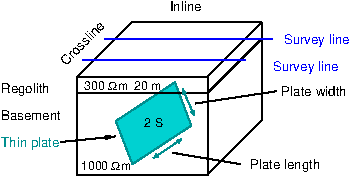

### Forward solver

The forward solver is LeroiAir (Raiche et. al, 2007) and the code has been reorganised so that the response measured by an AEM system is give by a function that can be called from Python. In LeroiAir plates are discretised into cells, with the accuracy of the forward solver a function of the chosen cell-size. The forward solver is kept in a seperate Python package that is available [here](https://github.com/JuergHauser/PyP223.git)


When modelling the electromagnetic response of subvertical bodies such as a VMS deposit they can be approximated using a thin plate in the halfspace of a layered earth, that is the forward solver computes the 3D response of a thin plate (e.g. Prikhodko et al. 2019). 

Successful inversion frequntly relies on the objective function being smooth and predictable. For the data being inverted here it is advantageous to convert measurements to scale logarithmically to obtain a smoother and more predictable objective function when compared with using the unscaled data. Similarly plate orientation angels are converted into radians. 


#### Jacobian via finite differencing

Parameter estimation methods frequently rely on the provision of a Jacobian for efficient optimisaiton. If an analytical Jacobian is not available it can be computed via finite differencing.

$
f'(x_0) = {f(x_0 +h)-f(x_0)\over h}
$

Care must be taken when choosing the step size $h$ as a too small step size my result in a Jacobian that is affected by a limited accuracy of the forward solver and a too large step size $h$ might result in a Jacobian that is not representative of the derivatives at location $x_0$. In the following we use a relative step size $q$ that is $h=x0*(1.0+q)$. Further to this the gradient of the objective functions itself is affected by the noise on the data, thus for noisy data choosing a larger step size when computing the Jacobian can be advisable.


#### VTEM max AEM system

Airborne electromagnetic systems can be categorised into either helicopter or fixed wing systems. The examples in this directory use a VTEM max system which is a helicopter based system developed and operated by Geotech.

https://geotech.ca/services/electromagnetic/vtem-versatile-time-domain-electromagnetic-system/



### Implementation details

The problem setup is imported from `forward_lib.py` but can be adjusted for other applications. The wrapper is created so that we can declare model parameters which are a subset of all the model parameters required by the forward solver. This allows to, for example, invert only for dip of the thin plate with all the other mode paremters assumed to be known. The thin plate is parameterised using the parametrisation introduced in (Hauser et. al. 2016). Compared to the commonly employed parametrisation with a plate reference point on the edge of the plate this parametrisation allows for a thin plate to grow and shrink around a plate refrerence point, without the need to move the reference point. This can be advantageous  when there is for example a borehole intersecting a thin plate.

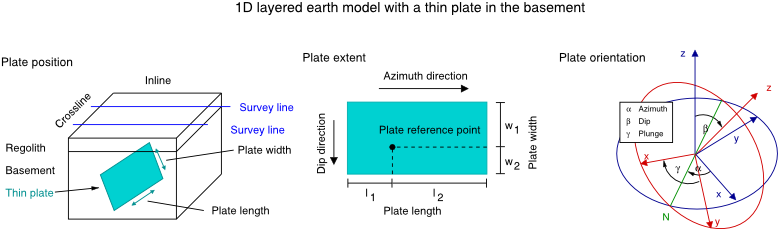



##### Further reading

Hauser, J., Gunning, J., & Annetts, D. (2016). Probabilistic inversion of airborne electromagnetic data for basement conductors. Geophysics, 81(5), E389-E400.

Prikhodko, A., Morrison, E., Bagrianski, A., Kuzmin, P., Tishin, P., & Legault, J. (2010). Evolution of VTEM? technical solutions for effective exploration. ASEG Extended Abstracts, 2010(1), 1-4.

Raiche, A., Sugeng, F. and Wilson, G. (2007) Practical 3D EM inversion the P223F software suite, ASEG Extended Abstracts, 2007:1, 1-5

Wheelock, B., Constable, S., & Key, K. (2015). The advantages of logarithmically scaled data for electromagnetic inversion. Geophysical Journal International, 201(3), 1765–1780. https://doi.org/10.1093/GJI/GGV107


In [60]:
import pickle
import functools

import numpy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import arviz
import cofi
import bayesbay

from forward_lib import (
    problem_setup, 
    system_spec,
    survey_setup, 
    true_model, 
    ForwardWrapper, 
    plot_transient,
    plot_predicted_profile,
    plot_plate_faces, 
    plot_plate_faces_single
)

numpy.random.seed(42)

### Problem definition
For convenience we split the problem defintion into three objects that intialised  with defaults for our synthetic example

- System specification - `system_spec` - contains information about the AEM system such as the transmitter waveform as well as start and an end times of gates.
- Survey setup - `survey_setup` - contains information about the survey spceifcall the transimtter and receiver locations
- Problem setup  - `problem_setup` - The problem setup cotains the model and exposes the declared moel paraemeters to CoFI.


In [4]:
survey_setup = {
    "tx": numpy.array([205.]),                  # transmitter easting/x-position
    "ty": numpy.array([100.]),                  # transmitter northing/y-position
    "tz": numpy.array([50.]),                   # transmitter height/z-position
    "tazi": numpy.deg2rad(numpy.array([90.])),  # transmitter azimuth
    "tincl": numpy.deg2rad(numpy.array([6.])),  # transmitter inclination
    "rx": numpy.array([205.]),                  # receiver easting/x-position
    "ry": numpy.array([100.]),                  # receiver northing/y-position
    "rz": numpy.array([50.]),                   # receiver height/z-position
    "trdx": numpy.array([0.]),                  # transmitter receiver separation inline
    "trdy": numpy.array([0.]),                  # transmitter receiver separation crossline
    "trdz": numpy.array([0.]),                  # transmitter receiver separation vertical
}

Intially we will only be inverting for the dip of the thin plate which is our declared model parameter

In [5]:
forward = ForwardWrapper(true_model, problem_setup, system_spec, survey_setup, ["pdip"])
true_param_value = numpy.array([60])

['pdip']


# Inverting for the dip of a thin plate
While a thin plate can not be recoverd from a single ficusial, its dip can be rcoeverd form carefully positoned fiducial. When setting up an inverse rpoblem it is good practice to initall setup a pth simpelst possible problem and us eit to ensure that hte forward solver and inference methods work as intendend.

#### True model

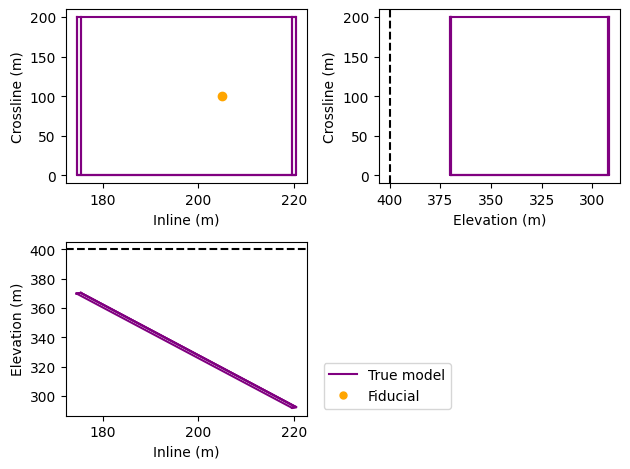

In [6]:
_, axes = plt.subplots(2, 2)
axes[1,1].axis("off")
plot_plate_faces(
    "plate_true", forward, true_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="purple", label="True model"
)
plt.tight_layout()
point = Line2D([0], [0], label='Fiducial', marker='o', markersize=5, 
         markeredgecolor='orange', markerfacecolor='orange', linestyle='')

handles, labels = axes[1,0].get_legend_handles_labels()
handles.extend([point])

axes[1,0].legend(handles=handles,bbox_to_anchor=(1.04, 0), loc="lower left")



#### Generate synthetic data 

This tutorial uses a simplfied noise model that assumes an absolute noise, that is a standard deviation of $0.05$ for the logarithms of the measured and observed data. In the objective fucntion the noise model is captured int he data covariance matrix thus a more sophisticated noise model for exmaple one that accounts for the known corrleation between time gates in AEM data could easily be implemented.

In [7]:
# The data 
absolute_noise= 0.05

# create data and ad a realisation of the noise
data_pred_true = forward(true_param_value)
data_obs = data_pred_true + numpy.random.randn(len(data_pred_true))*absolute_noise

# define data covariance matrix
sigma=absolute_noise
Cdinv=numpy.identity(len(data_obs))*(1.0/(sigma*sigma))

#### Starting model

Set an initial guess for the dip of the thin plate

In [8]:
init_param_value = numpy.array([45])

#### Define helper functions for CoFI

In [9]:
def my_objective(model):
    dpred = forward(model)
    residual = dpred - data_obs
    return residual.T @ Cdinv @ residual

def my_gradient(model):
    dpred = forward(model)
    jacobian = forward.jacobian(model, relative_step=0.1)
    residual = dpred - data_obs
    return jacobian.T @ Cdinv @ residual

def my_hessian(model):
    jacobian = forward.jacobian(model)
    return jacobian.T @ Cdinv @ jacobian

class PerIterationCallbackFunction:
    def __init__(self):
        self.x = None
        self.i = 0

    def __call__(self, xk):
        print(f"Iteration #{self.i+1}")
        print(f"  objective value: {my_problem.objective(xk)}")
        self.x = xk
        self.i += 1

#### Sensitivity of the misfit function and usefulness of the gradient

When setting up a new inverse problem prior to any inversion it makes sense to verify that the misfit function is sensitve to the parameter of itnerest and that the gradient of the objective function points in the right direction.

pdip: [40], data misfit: 231.708835656254, gradient: [-8.38525334]
pdip: [45], data misfit: 161.52059630302878, gradient: [-5.17711959]
pdip: [50], data misfit: 115.89689554155724, gradient: [-3.41393833]
pdip: [55], data misfit: 91.0843855955822, gradient: [-1.79238028]
pdip: [60], data misfit: 78.13208270691166, gradient: [-0.40612889]
pdip: [65], data misfit: 79.47542276986738, gradient: [0.60701868]
pdip: [70], data misfit: 86.57794284916837, gradient: [0.77951888]
pdip: [75], data misfit: 99.82377503892143, gradient: [1.04776418]
pdip: [80], data misfit: 114.82121927725917, gradient: [1.88028555]
pdip: [85], data misfit: 135.80364266137616, gradient: [1.99672184]
pdip: [90], data misfit: 158.91312196239573, gradient: [2.12201565]
pdip: [95], data misfit: 190.36506697630017, gradient: [1.90338506]
pdip: [100], data misfit: 211.34574782298415, gradient: [3.0843773]
pdip: [105], data misfit: 248.95857134110955, gradient: [3.54243063]
pdip: [110], data misfit: 283.9454162116735, gradi

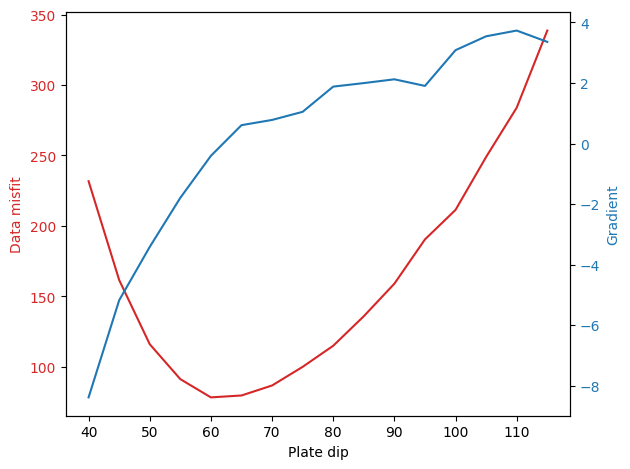

In [10]:
all_models = [numpy.array([pdip]) for pdip in range(40, 120, 5)]
all_misfits = []
all_gradients = []
for model in all_models:
    misfit = my_objective(model)
    gradient = my_gradient(model)
    all_misfits.append(misfit)
    all_gradients.append(gradient)
    print(f"pdip: {model}, data misfit: {misfit}, gradient: {gradient}")


fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(all_models, all_misfits,color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel("Plate dip")
ax1.set_ylabel("Data misfit",color=color)

ax2 = ax1.twinx() 
color = 'tab:blue'
ax2.plot(all_models, all_gradients,color=color)
ax2.set_ylabel('Gradient', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Parameter estimation

First we solve the inverse problem using optimisation that is we seek to find the minimum of the objective function given as

$$
\chi^2 = (\mathbf{d} - \mathbf{f}(\mathbf{m}))^T\mathbf{C}_d^{-1}(\mathbf{d}-\mathbf{f}(\mathbf{m})),
$$

with the full Newton step being

$$
\begin{equation} \Delta \mathbf{m}= (\underbrace{\mathbf{J}^T \mathbf{C}_d^{-1} \mathbf{J}}_{\mathbf{Hessian}})^{-1}
(\underbrace{ \mathbf{J}^T\mathbf{C}_d^{-1} 
(\mathbf{y}-\mathbf{f}(\mathbf{m}))}_\mathbf{Gradient}).
\end{equation} 
$$



#### Define CoFI problem

In [11]:
my_problem = cofi.BaseProblem()
my_problem.set_objective(my_objective)
my_problem.set_gradient(my_gradient)
my_problem.set_hessian(my_hessian)
my_problem.set_initial_model(init_param_value)

#### Define CoFI options

In [12]:
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method="Newton-CG",callback=PerIterationCallbackFunction())

#### CoFI inversion

In [13]:
my_inversion = cofi.Inversion(my_problem, my_options)
my_result = my_inversion.run()
print(my_result.model)

Iteration #1
  objective value: 77.89136366904667
Iteration #2
  objective value: 77.67785905000744
[59.18480808]


#### Plotting

##### Data

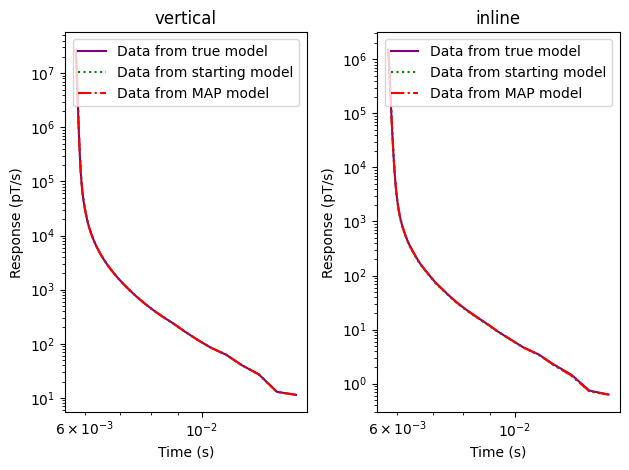

In [14]:
_, (ax1, ax2) = plt.subplots(1, 2)
plot_transient(true_param_value, forward, "Data from true model", ax1, ax2, color="purple")
plot_transient(init_param_value, forward, "Data from starting model", ax1, ax2, color="green", linestyle=":")
plot_transient(my_result.model, forward, "Data from MAP model", ax1, ax2, color="red", linestyle="-.")
ax1.legend(loc="upper center")
ax2.legend(loc="upper center")
ax1.set_title("vertical")
ax2.set_title("inline")
plt.tight_layout()

##### Model

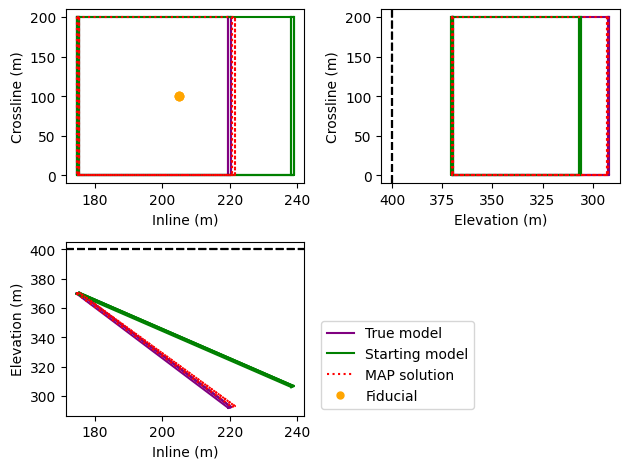

In [15]:
_, axes = plt.subplots(2, 2)
axes[1,1].axis("off")
plot_plate_faces(
    "plate_true", forward, true_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="purple", label="True model"
)
plot_plate_faces(
    "plate_init", forward, init_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="green", label="Starting model"
)
plot_plate_faces(
    "plate_inverted", forward, my_result.model, 
    axes[0,0], axes[0,1], axes[1,0], color="red", label="MAP solution", linestyle="dotted"
)
plt.tight_layout()
point = Line2D([0], [0], label='Fiducial', marker='o', markersize=5, 
         markeredgecolor='orange', markerfacecolor='orange', linestyle='')

handles, labels = axes[1,0].get_legend_handles_labels()
handles.extend([point])

axes[1,0].legend(handles=handles,bbox_to_anchor=(1.04, 0), loc="lower left")

## Ensemble method

Parameter estimation methods require an objective function while ensemble methods require a likelihood functions typically given in the form of a log likelidhood function. 
The objective function used for the parameter estimation consists of only a data misfit term and thus is closely related to the likelihood function, with the log likelihood  being proportional to the value of the objective function multiplied by a factor of $\frac{1}{2}$

$$
p({\mathbf d} | {\mathbf m}) \propto \exp \left\{- \frac{1}{2} ({\mathbf d}-{\mathbf f}({\mathbf m}))^T C_d^{-1} ({\mathbf d}-{\mathbf f}({\mathbf m})) \right\}
$$

In the following we define a log likelihood function and log prior function. The prior distribution is a uniform distribution with an lower boundary of $10 \degree$ and an upper boundary of $80 \degree$

In [16]:
def my_log_likelihood(model):
    return -0.5 * my_objective(model)

def my_log_prior(m):    # uniform distribution
    for i in range(len(m)):
        if m[i] < m_min[i] or m[i] > m_max[i]: return -numpy.inf
    return 0.0 # model lies within bounds -> return log(1)

In [17]:
m_min=numpy.array([10])
m_max=numpy.array([80])

#### Augment the CoFI problem

To be able to use an ensemble method we need to augment our CoFI problem with a function providing the log of the prior probability and a second function that provides the log of the likelihood function.

In [18]:
my_problem.set_log_prior(my_log_prior)
my_problem.set_log_likelihood(my_log_likelihood)
my_problem.set_model_shape(len(init_param_value))

#### Define CoFI options

In [19]:
nwalkers = 3
ndim = len(init_param_value)
nsteps = 500
walkers_start = init_param_value + 1 * numpy.random.randn(nwalkers, ndim)

#### CoFI Inversion

In [20]:
inv_options = cofi.InversionOptions()
inv_options.set_tool("emcee")
inv_options.set_params(nwalkers=nwalkers, nsteps=nsteps, initial_state=walkers_start, progress=True)

######## Run it
inv = cofi.Inversion(my_problem, inv_options)
inv_result = inv.run()

######## Check result
print(f"The inversion result from `emcee`:")
inv_result.summary()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [09:00<00:00,  1.08s/it]

The inversion result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


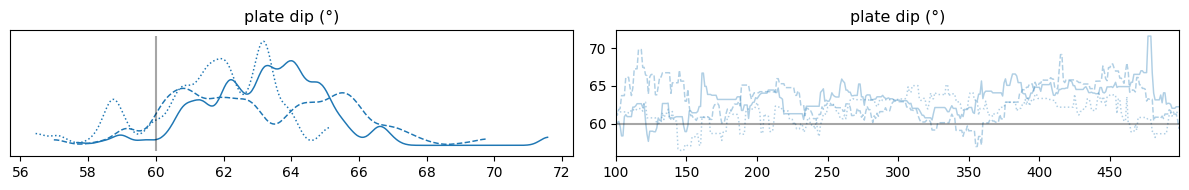

In [21]:
sampler = inv_result.sampler
arviz.style.use("default")
var_names = [
    "plate dip (\u00b0)", 
]
az_idata = inv_result.to_arviz(var_names=var_names)
arviz.plot_trace(az_idata.sel(draw=slice(100,None)),lines=(('plate dip (\u00b0)', {}, 60),));
plt.tight_layout()

# Inverting for a thin plate given three survey lines

A more realistic synthetic example is the inference of a thin plate target given three survey lines. It now becomes possible to invert for the easting, depth of the plate reference point, the plate dip and plate azimuth and the plate length.


### Survey setup

In [22]:
tx_min = 115
tx_max = 281
tx_interval = 15
ty_min = 25
ty_max = 176
ty_interval = 75
tx_points = numpy.arange(tx_min, tx_max, tx_interval)
ty_points = numpy.arange(ty_min, ty_max, ty_interval)
n_transmitters = len(tx_points) * len(ty_points)
tx, ty = numpy.meshgrid(tx_points, ty_points)
tx = tx.flatten()
ty = ty.flatten()

In [23]:
fiducial_id = numpy.arange(len(tx))
line_id = numpy.zeros(len(tx), dtype=int)
line_id[ty==ty_points[0]] = 0
line_id[ty==ty_points[1]] = 1
line_id[ty==ty_points[2]] = 2

In [24]:
survey_setup = {
    "tx": tx,                                                   # transmitter easting/x-position
    "ty": ty,                                                   # transmitter northing/y-position
    "tz": numpy.array([50]*n_transmitters),                     # transmitter height/z-position
    "tazi": numpy.deg2rad(numpy.array([90]*n_transmitters)),    # transmitter azimuth
    "tincl": numpy.deg2rad(numpy.array([6]*n_transmitters)),    # transmitter inclination
    "rx": tx,                                                   # receiver easting/x-position
    "ry": numpy.array([100]*n_transmitters),                    # receiver northing/y-position
    "rz": numpy.array([50]*n_transmitters),                     # receiver height/z-position
    "trdx": numpy.array([0]*n_transmitters),                    # transmitter receiver separation inline
    "trdy": numpy.array([0]*n_transmitters),                    # transmitter receiver separation crossline
    "trdz": numpy.array([0]*n_transmitters),                    # transmitter receiver separation vertical
    "fiducial_id": fiducial_id,                                 # unique id for each transmitter
    "line_id": line_id                  # id for each line
}

### True model

In [25]:
true_model = {
    "res": numpy.array([300, 1000]), 
    "thk": numpy.array([20]), 
    "peast": numpy.array([175]), 
    "pnorth": numpy.array([100]), 
    "ptop": numpy.array([30]), 
    "pres": numpy.array([0.1]), 
    "plngth1": numpy.array([100]), 
    "plngth2": numpy.array([100]), 
    "pwdth1": numpy.array([0.1]), 
    "pwdth2": numpy.array([90]), 
    "pdzm": numpy.array([75]),
    "pdip": numpy.array([60])
}

In [26]:
forward = ForwardWrapper(true_model, problem_setup, system_spec, survey_setup,
                         ["pdip","pdzm", "peast", "pwdth2","ptop"], data_returned=["vertical"]);

['pdip', 'pdzm', 'peast', 'pwdth2', 'ptop']


In [27]:
# check the order of parameters in a model vector
forward.params_to_invert

['pdip', 'pdzm', 'peast', 'ptop', 'pwdth2']

In [28]:
true_param_value = numpy.array([60,65, 175, 30, 90])

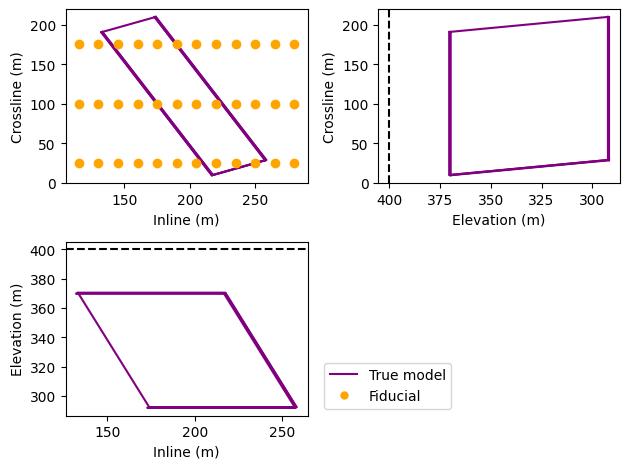

In [29]:
_, axes = plt.subplots(2, 2)
axes[1,1].axis("off")
plot_plate_faces(
    "plate_true", forward, true_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="purple", label="True model"
)
plt.tight_layout()
point = Line2D([0], [0], label='Fiducial', marker='o', markersize=5, 
         markeredgecolor='orange', markerfacecolor='orange', linestyle='')

handles, labels = axes[1,0].get_legend_handles_labels()
handles.extend([point])

axes[1,0].legend(handles=handles,bbox_to_anchor=(1.04, 0), loc="lower left")

### Generate synthetic data

In [30]:
# The data 
absolute_noise= 0.05

# create data and ad a realisation of the noise
data_pred_true = forward(true_param_value)
data_obs = data_pred_true + numpy.random.randn(len(data_pred_true))*absolute_noise

# define data covariance matrix
sigma=absolute_noise
Cdinv=numpy.identity(len(data_obs))*(1.0/(sigma*sigma))

## Parameter estimation

**Initialise a model for inversion**

In [31]:
init_param_value = numpy.array([45, 90, 150, 20, 80])

**Define helper functions for CoFI**

In [32]:
def my_objective(model):
    dpred = forward(model)
    residual = dpred - data_obs
    return residual.T @ Cdinv @ residual

def my_gradient(model):
    dpred = forward(model)
    jacobian = forward.jacobian(model, relative_step=0.1)
    residual = dpred - data_obs
    return jacobian.T @ Cdinv @ residual

def my_hessian(model):
    jacobian = forward.jacobian(model)
    return jacobian.T @ Cdinv @ jacobian

class PerIterationCallbackFunction:
    def __init__(self):
        self.x = None
        self.i = 0

    def __call__(self, xk):
        print(f"Iteration #{self.i+1}")
        print(f"  objective value: {my_problem.objective(xk)}")
        self.x = xk
        self.i += 1

**Define CoFI problem**

In [33]:
my_problem = cofi.BaseProblem()
my_problem.set_objective(my_objective)
my_problem.set_gradient(my_gradient)
my_problem.set_hessian(my_hessian)
my_problem.set_initial_model(init_param_value)

**Define CoFI options**

In [34]:
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method="Newton-CG",callback=PerIterationCallbackFunction())

**Run CoFI inversion**

In [35]:
my_inversion = cofi.Inversion(my_problem, my_options)
my_result = my_inversion.run()
print(my_result.model)

Iteration #1
  objective value: 27956.108513885774
Iteration #2
  objective value: 8021.757584898161
Iteration #3
  objective value: 3338.2923104284337
Iteration #4
  objective value: 2041.8444603500957
Iteration #5
  objective value: 1790.215243380117
Iteration #6
  objective value: 1571.1725685763995
Iteration #7
  objective value: 1565.4378048652256
Iteration #8
  objective value: 1556.7958181482293
[ 59.96721758  65.07888087 174.69896561  30.41831984  90.75800143]


In [36]:
## Plotting

In [37]:
### Data - Profiles

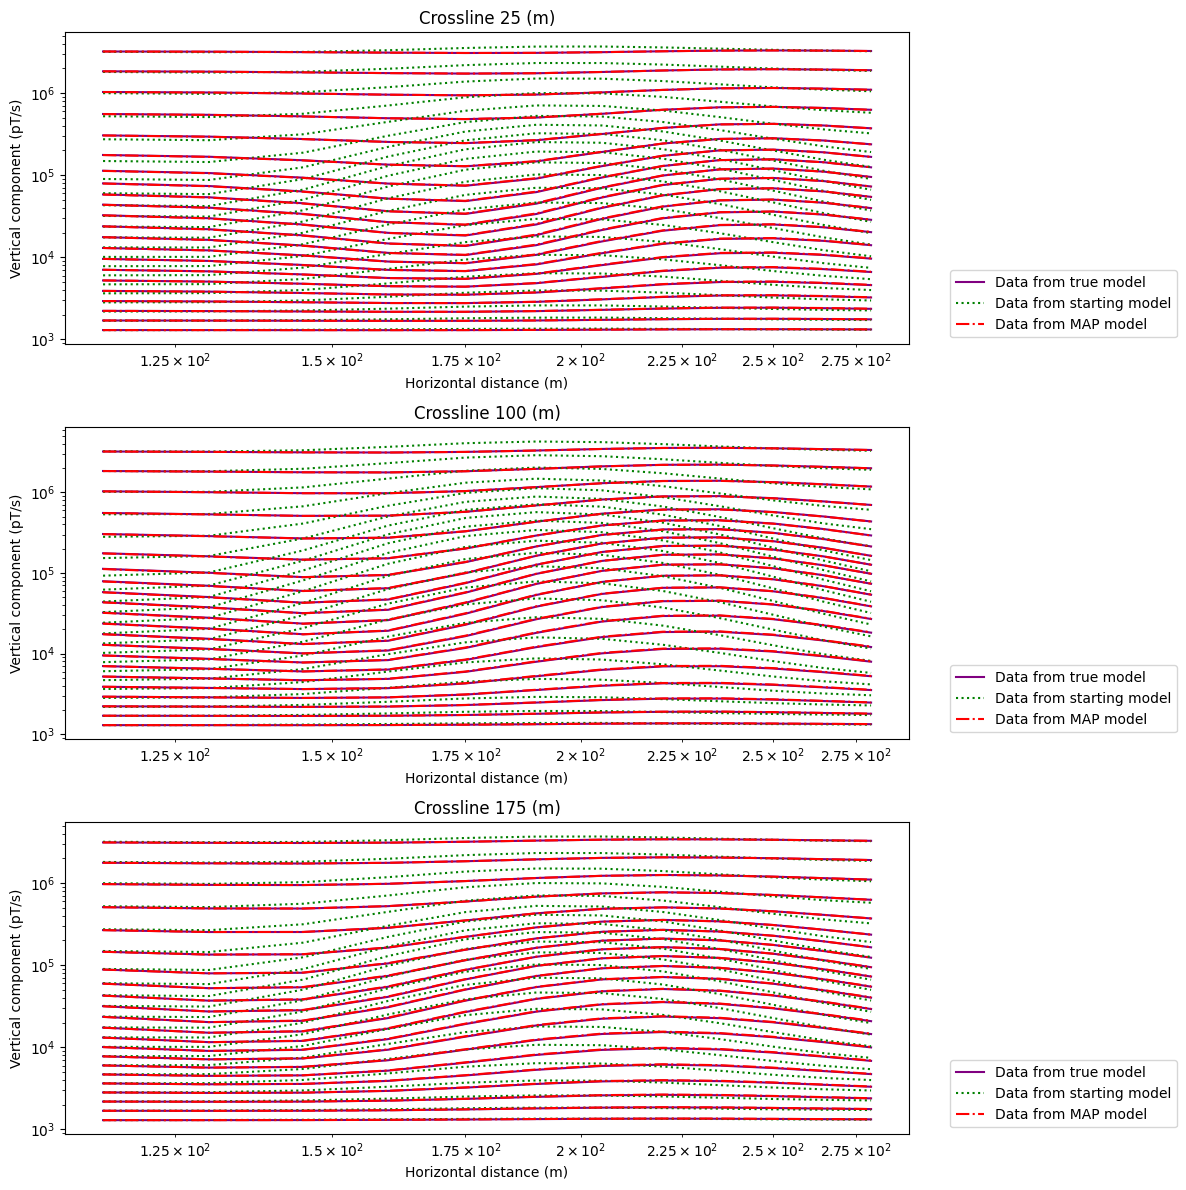

In [38]:
# Select gates to plot
idx_to_plot = numpy.arange(8, 30) 

_, axes = plt.subplots(3, 1, figsize=(12,12))

for i in range(3):
    plot_predicted_profile(true_param_value, forward, "Data from true model", gate_idx=idx_to_plot, 
                                        line_id=[i], ax=axes[i], color="purple")
    plot_predicted_profile(init_param_value, forward, "Data from starting model", gate_idx=idx_to_plot, 
                                        line_id=[i], ax=axes[i], color="green", linestyle=":")
    plot_predicted_profile(my_result.model, forward, "Data from MAP model", gate_idx=idx_to_plot, 
                                        line_id=[i], ax=axes[i], color="red", linestyle="-.")
    axes[i].set_title("Crossline {} (m)".format(ty_points[i]))
    axes[i].legend(bbox_to_anchor=(1.04, 0), loc="lower left")
plt.tight_layout()

### Model
 As a general rule we can only constrain parateters if there are fiducials in the survey that are sensitive to them and also fiducials that are not sensitive to them. In order words the anomly needs to be closed with respect to the model paratmeter in question. So to be able to constraint plate lenghy we would need survey lines to the north and south that are not overflying the thin plate.

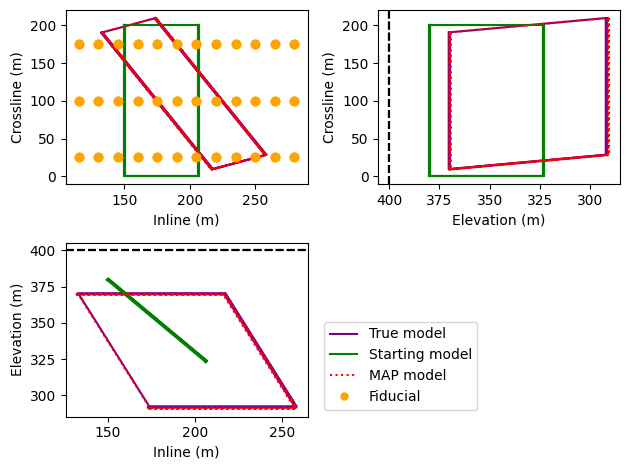

In [39]:
_, axes = plt.subplots(2, 2)
axes[1,1].axis("off")
plot_plate_faces(
    "plate_true", forward, true_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="purple", label="True model"
)
plot_plate_faces(
    "plate_init", forward, init_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="green", label="Starting model"
)
plot_plate_faces(
    "plate_inverted", forward, my_result.model, 
    axes[0,0], axes[0,1], axes[1,0], color="red", label="MAP model", linestyle="dotted"
)

plt.tight_layout()

point = Line2D([0], [0], label='Fiducial', marker='o', markersize=5, 
         markeredgecolor='orange', markerfacecolor='orange', linestyle='')

handles, labels = axes[1,0].get_legend_handles_labels()
handles.extend([point])

axes[1,0].legend(handles=handles,bbox_to_anchor=(1.04, 0), loc="lower left")

## Ensemble methods

To speed up the forward computations for this tutorial we create a surrogate model for the objective function.                       

In [42]:
filename = "kriging_surrogate_model.pkl"
with open(filename, "rb") as f:
   sm = pickle.load(f)

**Initialise a model for inversion**

In [44]:
init_param_value = numpy.array([45, 90, 160, 35, 80])
m_min = numpy.array([15, 35, 155, 30, 65])
m_max = numpy.array([75, 145, 185, 40, 115])

**Define helper functions for CoFI**

In [184]:
def my_objective(model):
    val=sm.predict_values(numpy.array([model]))[0][0]
    if val<1e-3:
        return 1e-3
    else:
        return val
        
def my_log_likelihood(model):
    return -0.5 * my_objective(model)


def my_log_prior(model):    # uniform distribution
    for i in range(len(model)):
        if model[i] < m_min[i] or model[i] > m_max[i]: return -numpy.inf
    return 0.0 # model lies within bounds -> return log(1)

### Affine Invariant Marko chain Monte Carlo (McMC) Enemable smapler - emcee

In [135]:
my_problem = cofi.BaseProblem()
my_problem.set_log_prior(my_log_prior)
my_problem.set_log_likelihood(my_log_likelihood)
my_problem.set_model_shape(len(init_param_value))

**Define CoFI options**

In [136]:
nwalkers = 12
ndim = len(init_param_value)
nsteps = 5000
walkers_start = init_param_value + 0.5 * numpy.random.randn(nwalkers, ndim)



In [137]:
inv_options = cofi.InversionOptions()
inv_options.set_tool("emcee")
inv_options.set_params(nwalkers=nwalkers, nsteps=nsteps, initial_state=walkers_start, progress=True)

######## Run it
inv = cofi.Inversion(my_problem, inv_options)
inv_result = inv.run()

######## Check result
print(f"The inversion result from `emcee`:")
inv_result.summary()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 295.72it/s]

The inversion result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


In [ ]:
## Plotting

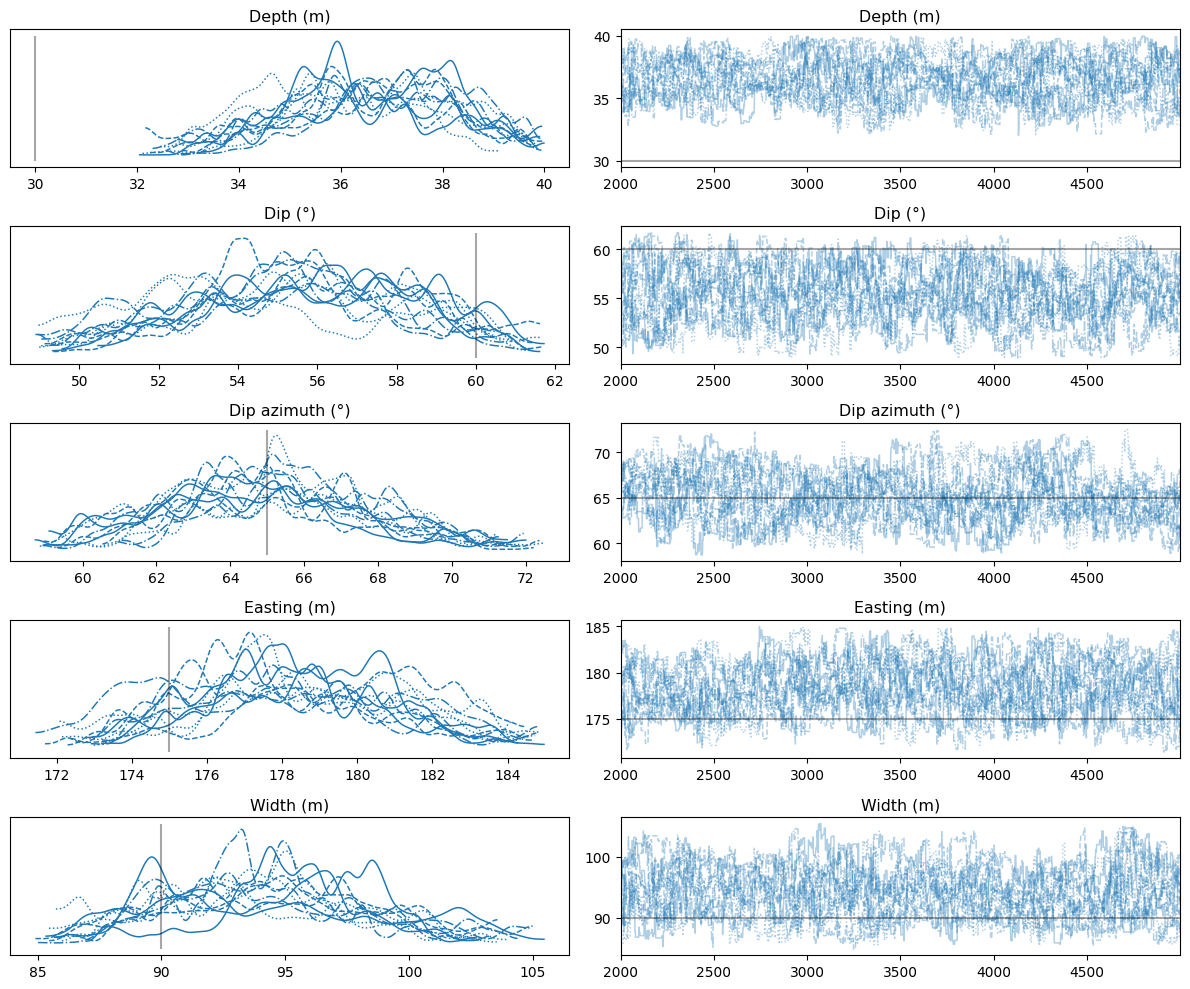

In [53]:
arviz.style.use("default")

var_names = [
    "Dip (\u00b0)",
    "Dip azimuth (\u00b0)",
    "Easting (m)",
    "Depth (m)",
    "Width (m)",
]

var_lines=(
        ('Dip (\u00b0)', {}, 60),
        ('Dip azimuth (\u00b0)', {}, 65),
        ('Easting (m)', {}, 175),
        ('Depth (m)', {}, 30),
        ('Width (m)', {}, 90)
)
sampler = inv_result.sampler
az_idata = inv_result.to_arviz(var_names=var_names)
arviz.plot_trace(az_idata.sel(draw=slice(2000,None)),lines=var_lines);
plt.tight_layout()

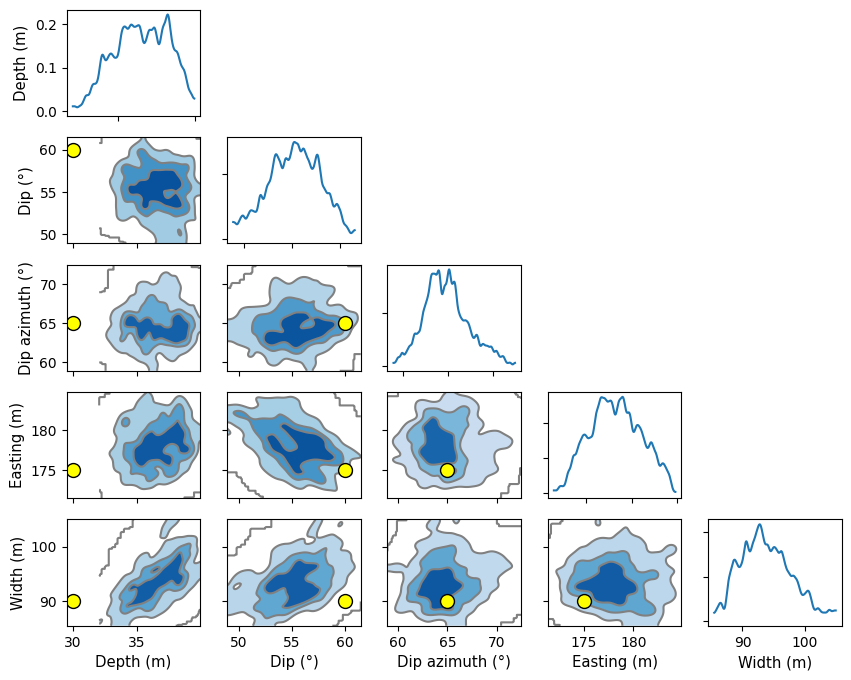

In [54]:
true_values = {
    f"{var_names[i]}": true_param_value[i] for i in range(init_param_value.size)
}
fig, axes = plt.subplots(5, 5, figsize=(10, 8))
_ = arviz.plot_pair(
az_idata.sel(draw=slice(4000,None)), 
    marginals=True,
    kind="kde",
    kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Blues"},
    },
    ax=axes,
    textsize=10,
)

for i, j in numpy.ndindex(axes.shape):
    if i == j:
        continue
    xlabel = axes[-1, j].get_xlabel()
    ylabel = axes[i, 0].get_ylabel()
    x_true = true_values[xlabel]
    y_true = true_values[ylabel]        
    axes[i, j].plot(x_true, y_true, "yellow", marker="o", ms=10, markeredgecolor="k")

plt.show()

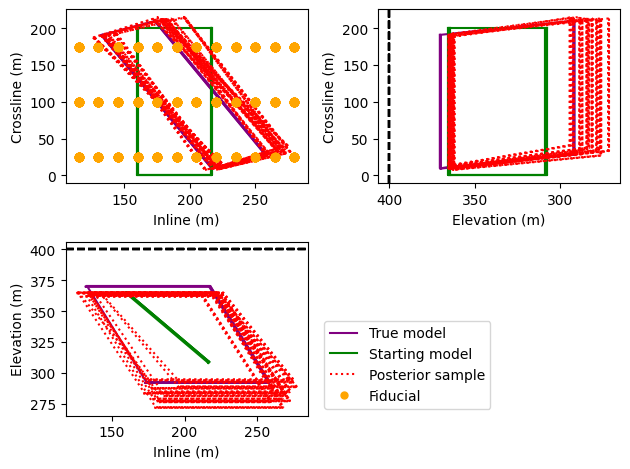

In [56]:
arviz.style.use("default")

_, axes = plt.subplots(2, 2)
axes[1,1].axis("off")
plot_plate_faces(
    "plate_true", forward, true_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="purple", label="True model"
)
plot_plate_faces(
    "plate_init", forward, init_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="green", label="Starting model"
)


plt.tight_layout()


ichain=0
idraw=2500
sample=numpy.zeros(5)

sample[0]=az_idata.posterior['Dip (\u00b0)'][ichain][idraw]
sample[1]=az_idata.posterior['Dip azimuth (\u00b0)'][ichain][idraw]
sample[2]=az_idata.posterior['Easting (m)'][ichain][idraw]
sample[3]=az_idata.posterior['Depth (m)'][ichain][idraw]
sample[4]=az_idata.posterior['Width (m)'][ichain][idraw]
plot_plate_faces(
    "plate_inverted", forward, sample, 
    axes[0,0], axes[0,1], axes[1,0], color="red", label="Posterior sample", linestyle="dotted"
)

point = Line2D([0], [0], label='Fiducial', marker='o', markersize=5, 
         markeredgecolor='orange', markerfacecolor='orange', linestyle='')

handles, labels = axes[1,0].get_legend_handles_labels()
handles.extend([point])

axes[1,0].legend(handles=handles,bbox_to_anchor=(1.04, 0), loc="lower left")


# plot 10 randomly selected samples of the posterior distirbution
for i in range(10):
    ichain=numpy.random.randint(0,12)
    idraw=numpy.random.randint(2000,5000)
    sample[0]=az_idata.posterior['Dip (\u00b0)'][ichain][idraw]
    sample[1]=az_idata.posterior['Dip azimuth (\u00b0)'][ichain][idraw]
    sample[2]=az_idata.posterior['Easting (m)'][ichain][idraw]
    sample[3]=az_idata.posterior['Depth (m)'][ichain][idraw]
    sample[4]=az_idata.posterior['Width (m)'][ichain][idraw]
    plot_plate_faces(
    "plate_inverted", forward, sample, 
    axes[0,0], axes[0,1], axes[1,0], color="red", label="Posterior sample", linestyle="dotted"
)


### Neighobourhood algorithm - neighpy

In [103]:
my_problem = cofi.BaseProblem()
my_problem.set_objective(my_objective)

In [104]:
inv_options = cofi.InversionOptions()
inv_options.set_tool("neighpy")
inv_options.suggest_solver_params()

Current backend tool neighpy has the following solver-specific parameters:
Required parameters:
{'direct_search_ni', 'direct_search_nr', 'appraisal_n_walkers', 'bounds', 'direct_search_ns', 'appraisal_n_resample', 'direct_search_n'}
Optional parameters & default settings:
-- nothing --


In [105]:

inv_options.set_params(
    direct_search_ni=1000,
    direct_search_ns=100,
    direct_search_nr=20,
    direct_search_n=10,
    bounds=numpy.array([m_min, m_max]).T,
    appraisal_n_resample=10000,
    appraisal_n_walkers=4
)

######## Run it
inv = cofi.Inversion(my_problem, inv_options)
inv_result = inv.run()

######## Check result
print(f"The inversion result from `neighpy`:")
inv_result.summary()

NAI - Initial Random Search


NAII - Random Walk: 100%|█████████▉| 2494/2500 [00:25<00:00, 102.52it/s]

The inversion result from `neighpy`:
Summary for inversion result
SUCCESS
----------------------------
model: [ 58.57102939  63.0564343  171.30890139  36.49185016  97.7961164 ]
direct_search_samples: [[ 55.74856303  96.61932261 169.13408571  30.95406274  73.26955203]
 [ 37.00948086  41.14091046 163.70185256  32.81716717  97.49405123]
 [ 59.44994474  43.83995875 181.62415231  32.80641089  73.31715024]
 ...
 [ 58.56981625  62.62158456 171.30878678  36.49172608  97.7972036 ]
 [ 58.56983694  62.62101458 171.3088375   36.4917796   97.79692986]
 [ 58.56973533  62.62067449 171.30882308  36.4917113   97.79708202]]
direct_search_objectives: [19240.51294094 59379.45639081 26720.0598972  ...   142.44157565
   142.45306902   142.50632209]
appraisal_samples: [[ 61.46408295  74.30969344 173.138494    37.1013434   92.61361569]
 [ 64.02073462  65.23140734 173.65232873  37.33086499  98.50743184]
 [ 69.99337884  65.08405388 172.37131934  36.89015909  93.92631914]
 ...
 [ 61.49899538  74.13528816 172.543

NAII - Random Walk: 100%|██████████| 2500/2500 [00:25<00:00, 98.56it/s] 


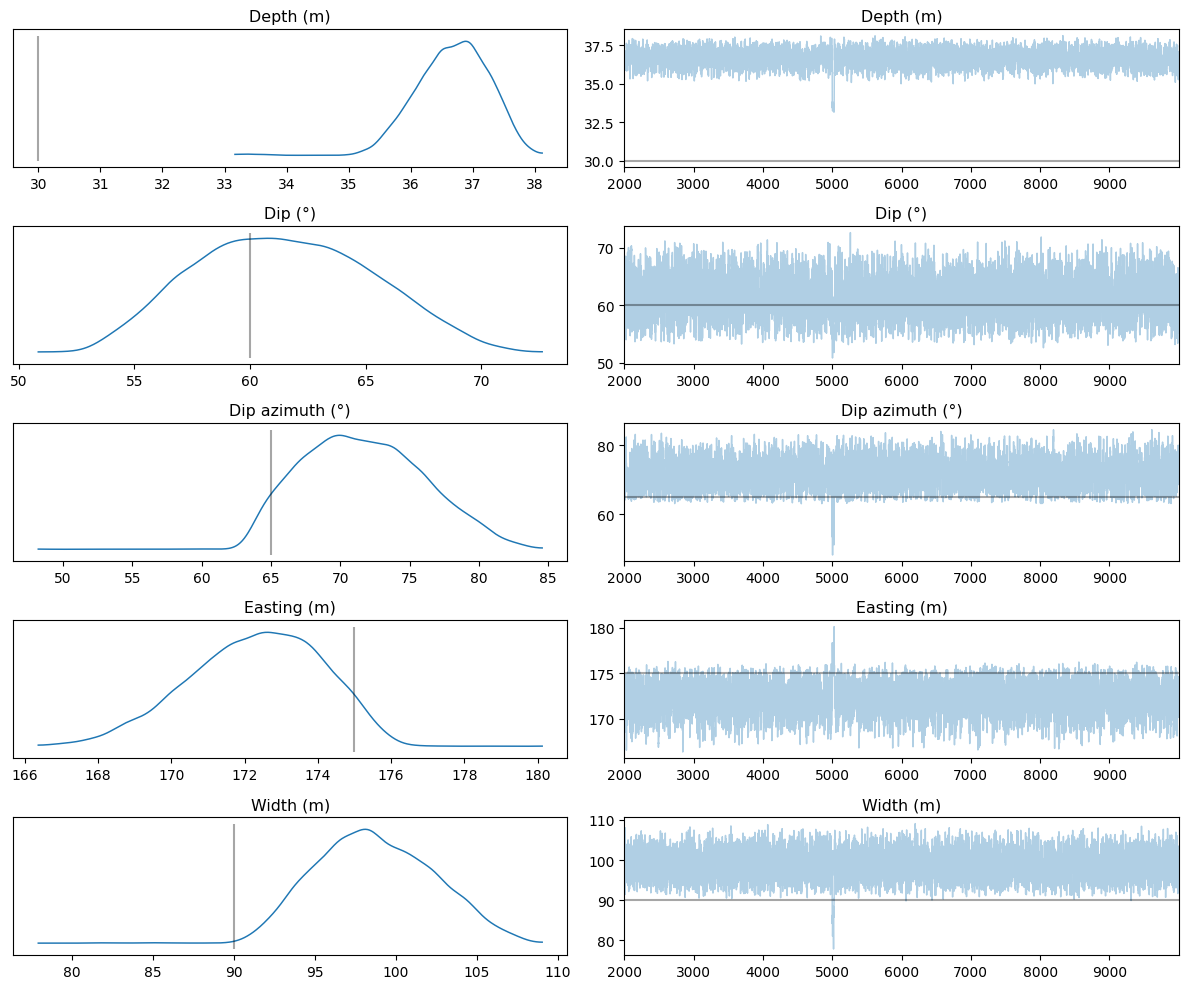

In [106]:
arviz.style.use("default")
var_names = [
    "Dip (\u00b0)", 
    "Dip azimuth (\u00b0)", 
    "Easting (m)", 
    "Depth (m)", 
    "Width (m)"
]

var_lines=(
    ('Dip (\u00b0)', {}, 60),
        ('Dip azimuth (\u00b0)', {}, 65),
        ('Easting (m)', {}, 175),
        ('Depth (m)', {}, 30),
        ('Width (m)', {}, 90)
)
d = {k: v for k, v in zip(var_names, inv_result.appraisal_samples.T)}
az_idata = arviz.convert_to_inference_data(d)
arviz.plot_trace(az_idata.sel(draw=slice(2000,None)),lines=var_lines)
plt.tight_layout()

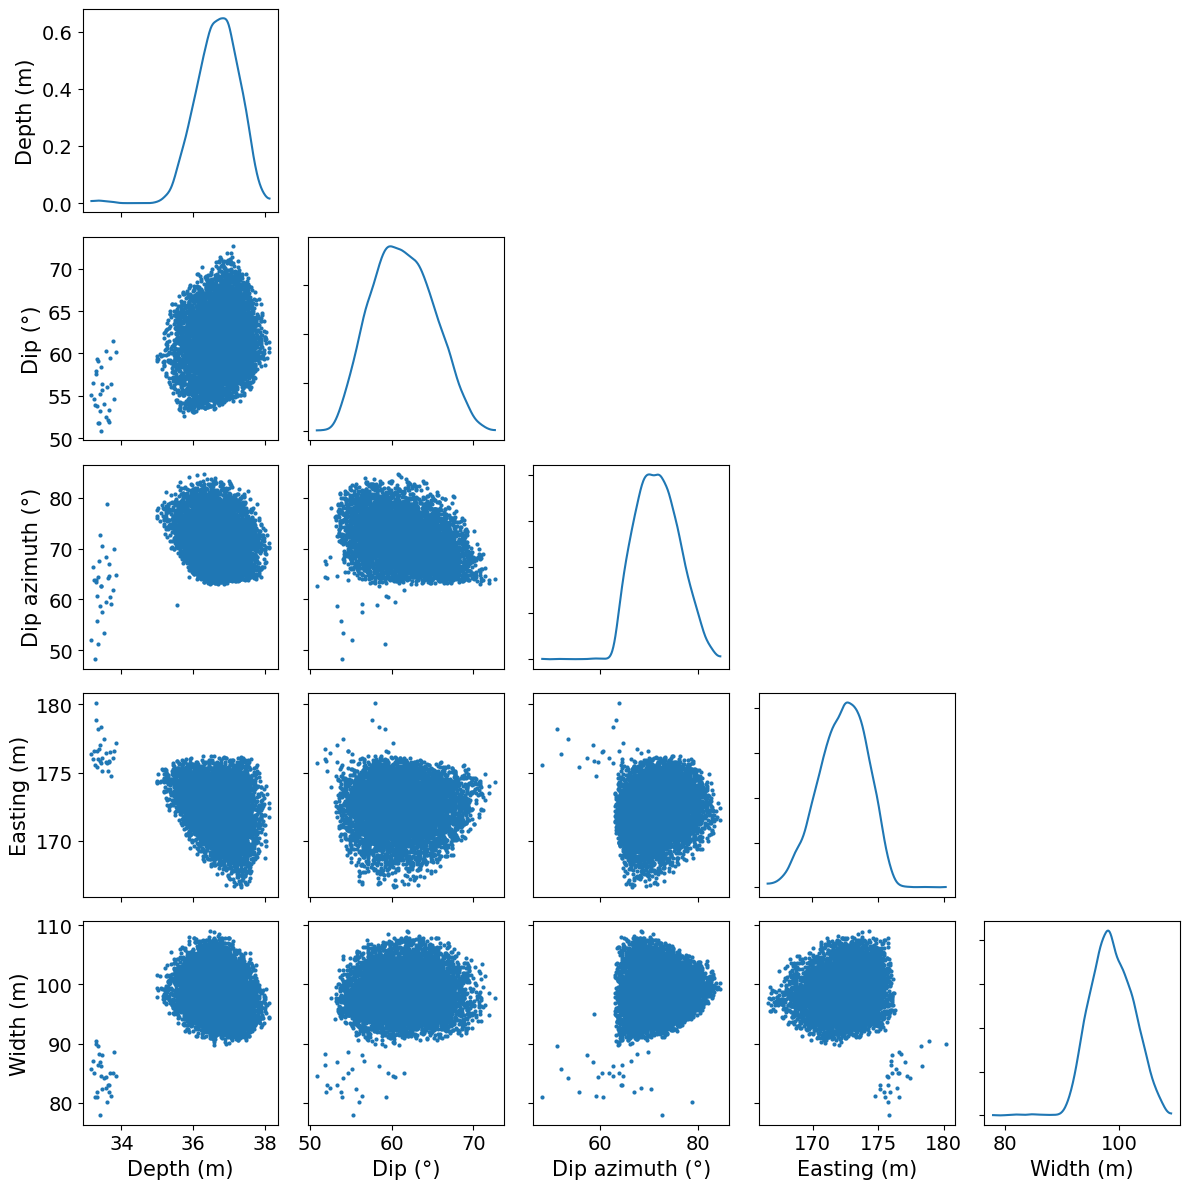

In [107]:
arviz.style.use("default")

_, axes = plt.subplots(5, 5, figsize=(12,12))
arviz.plot_pair(
    az_idata.sel(draw=slice(4000,None)), 
    marginals=True, 
    ax = axes
)
plt.tight_layout()

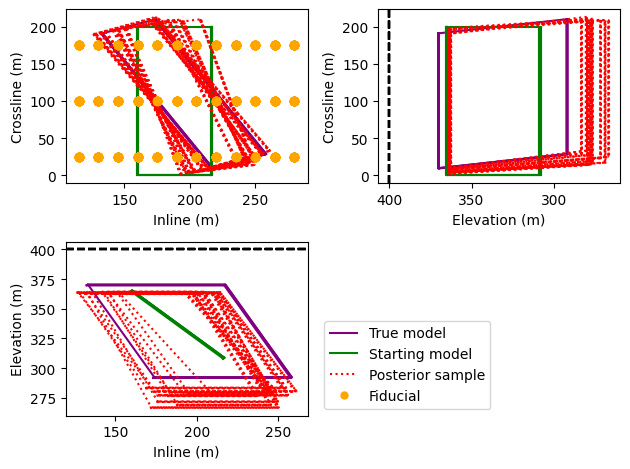

In [108]:
arviz.style.use("default")

_, axes = plt.subplots(2, 2)
axes[1,1].axis("off")
plot_plate_faces(
    "plate_true", forward, true_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="purple", label="True model"
)
plot_plate_faces(
    "plate_init", forward, init_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="green", label="Starting model"
)


plt.tight_layout()


ichain=0
idraw=2500
sample=numpy.zeros(5)

sample[0]=az_idata.posterior['Dip (\u00b0)'][ichain][idraw]
sample[1]=az_idata.posterior['Dip azimuth (\u00b0)'][ichain][idraw]
sample[2]=az_idata.posterior['Easting (m)'][ichain][idraw]
sample[3]=az_idata.posterior['Depth (m)'][ichain][idraw]
sample[4]=az_idata.posterior['Width (m)'][ichain][idraw]
plot_plate_faces(
    "plate_inverted", forward, sample, 
    axes[0,0], axes[0,1], axes[1,0], color="red", label="Posterior sample", linestyle="dotted"
)

point = Line2D([0], [0], label='Fiducial', marker='o', markersize=5, 
         markeredgecolor='orange', markerfacecolor='orange', linestyle='')

handles, labels = axes[1,0].get_legend_handles_labels()
handles.extend([point])

axes[1,0].legend(handles=handles,bbox_to_anchor=(1.04, 0), loc="lower left")


# plot 10 randomly selected samples of the posterior distirbution
for i in range(10):
    idraw=numpy.random.randint(2000,5000)
    sample[0]=az_idata.posterior['Dip (\u00b0)'][ichain][idraw]
    sample[1]=az_idata.posterior['Dip azimuth (\u00b0)'][ichain][idraw]
    sample[2]=az_idata.posterior['Easting (m)'][ichain][idraw]
    sample[3]=az_idata.posterior['Depth (m)'][ichain][idraw]
    sample[4]=az_idata.posterior['Width (m)'][ichain][idraw]
    plot_plate_faces(
    "plate_inverted", forward, sample, 
    axes[0,0], axes[0,1], axes[1,0], color="red", label="Posterior sample", linestyle="dotted"
)


###  Reversible-jump Markov chain Monte Carlo -  BayesBay

In [185]:
def initialize_param(param, position=None, value=1):
    return np.array([value]) + 0.5 * np.random.randn()

parameters = []
for iparam, (vmin, vmax) in enumerate(zip(m_min, m_max)):
    parameter = bayesbay.prior.UniformPrior(
        name=f"m{iparam}",
        vmin=m_min[iparam],
        vmax=m_max[iparam],
        perturb_std=(vmax - vmin) / 20,
    )
    custom_init = functools.partial(initialize_param, value=init_param_value[iparam])
    parameter.set_custom_initialize(custom_init)
    parameters.append(parameter)

param_space = bayesbay.parameterization.ParameterSpace(
    name="param_space",
    n_dimensions=1,
    parameters=parameters,
)
parameterization = bayesbay.parameterization.Parameterization(param_space)

In [186]:
def my_log_likelihood(state, *args, **kwargs):
    model = numpy.array(
        [state["param_space"][f"m{i}"] for i in range(init_param_value.size)]
    )
    return -0.5 * my_objective(model.T[0])

#log_likelihood = bayesbay.likelihood.LogLikelihood(log_like_func=my_log_likelihood) # BayesBay pre version 3.0
log_likelihood = bayesbay.LogLikelihood(log_like_func=my_log_likelihood)  # BayesBay version 3.0 and above

In [187]:
n_chains = 12
walkers_start = []
for i in range(n_chains):
    walkers_start.append(
        parameterization.initialize()
    )  # A bayesbay.State is appended to walkers_start for each chain

In [188]:
inv_options = cofi.InversionOptions()
inv_options.set_tool("bayesbay")
inv_options.set_params(
    walkers_starting_states=walkers_start,
    #perturbation_funcs=parameterization.perturbation_funcs,  # BayesBay pre version 3.0
    perturbation_funcs=parameterization.perturbation_functions, # BayesBay version 3.0 and above
    log_like_ratio_func=log_likelihood,
    n_chains=n_chains,
    n_iterations=5_000,
    burnin_iterations=500,
    verbose=False,
    save_every=25,
)

In [189]:
inv = cofi.Inversion(cofi.BaseProblem(), inv_options)
inv_result = inv.run()

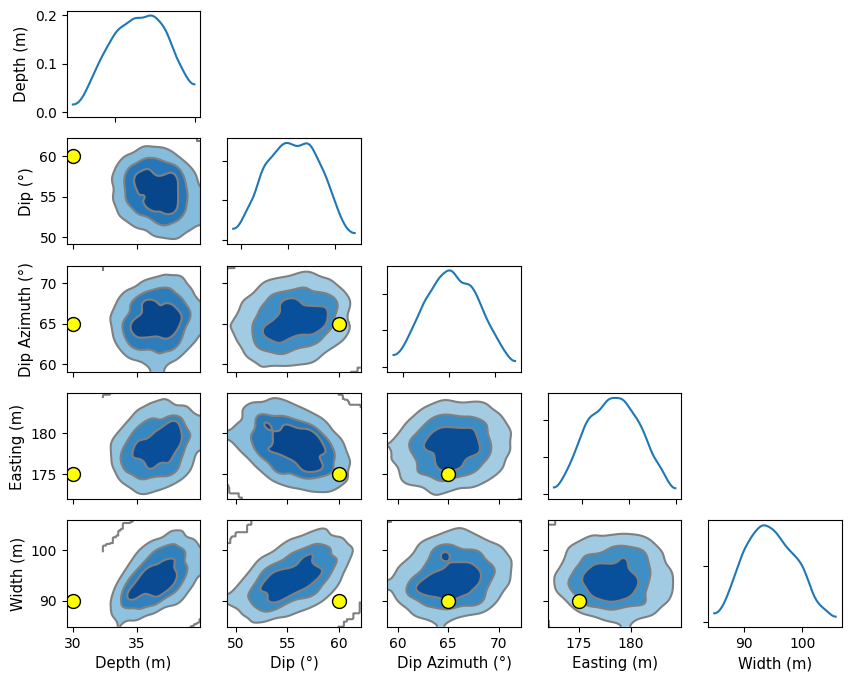

In [190]:
arviz.style.use("default")
var_names = [
    "Dip (\u00b0)",
    "Dip Azimuth (\u00b0)",
    "Easting (m)",
    "Depth (m)",
    "Width (m)",
]

results = inv_result.models
posterior_samples = {
    f"{var_names[i]}": np.concatenate(results[f"param_space.m{i}"])
    for i in range(init_param_value.size)
}

true_values = {
    f"{var_names[i]}": true_param_value[i] for i in range(init_param_value.size)
}


fig, axes = plt.subplots(5, 5, figsize=(10, 8))
_ = arviz.plot_pair(
    posterior_samples,
    marginals=True,
    kind="kde",
    kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Blues"},
    },
    ax=axes,
    textsize=10,
)

for i, j in np.ndindex(axes.shape):
    if i == j:
        continue
    xlabel = axes[-1, j].get_xlabel()
    ylabel = axes[i, 0].get_ylabel()
    x_true = true_values[xlabel]
    y_true = true_values[ylabel]
    axes[i, j].plot(x_true, y_true, "yellow", marker="o", ms=10, markeredgecolor="k")

plt.show()

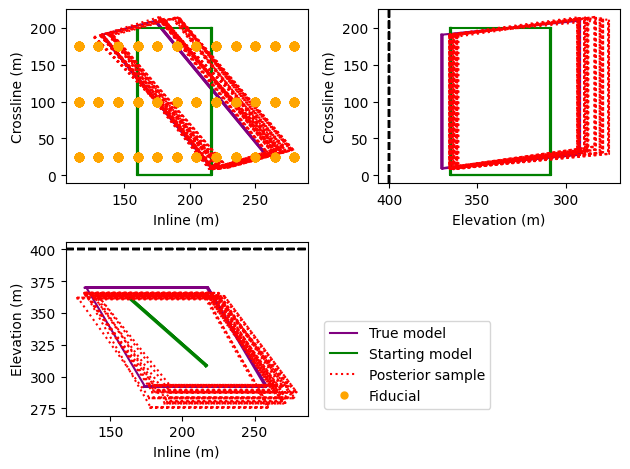

In [191]:
_, axes = plt.subplots(2, 2)
axes[1, 1].axis("off")
plot_plate_faces(
    "plate_true",
    forward,
    true_param_value,
    axes[0, 0],
    axes[0, 1],
    axes[1, 0],
    color="purple",
    label="True model",
)
plot_plate_faces(
    "plate_init",
    forward,
    init_param_value,
    axes[0, 0],
    axes[0, 1],
    axes[1, 0],
    color="green",
    label="Starting model",
)


plt.tight_layout()


idraw = np.random.randint(0, len(posterior_samples[var_names[0]]))

sample = np.array([posterior_samples[name][idraw] for name in var_names])

plot_plate_faces(
    "plate_inverted",
    forward,
    sample,
    axes[0, 0],
    axes[0, 1],
    axes[1, 0],
    color="red",
    label="Posterior sample",
    linestyle="dotted",
)

point = Line2D(
    [0],
    [0],
    label="Fiducial",
    marker="o",
    markersize=5,
    markeredgecolor="orange",
    markerfacecolor="orange",
    linestyle="",
)

handles, labels = axes[1, 0].get_legend_handles_labels()
handles.extend([point])

axes[1, 0].legend(handles=handles, bbox_to_anchor=(1.04, 0), loc="lower left")


# plot 10 randomly selected samples of the posterior distribution

idraws = np.random.choice(
    np.arange(0, len(posterior_samples[var_names[0]])), 10, replace=False
)
for idraw in idraws:
    sample = np.array([posterior_samples[name][idraw] for name in var_names])
    plot_plate_faces(
        "plate_inverted",
        forward,
        sample,
        axes[0, 0],
        axes[0, 1],
        axes[1, 0],
        color="red",
        label="Posterior sample",
        linestyle="dotted",
    )

# Where to next?

This tutorial is a based on the material avaiable as a a cofi example under the following link.

https://github.com/inlab-geo/cofi-examples/tree/main/examples/vtem_max




---
# Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [194]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib","bayesbay"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.9
numpy 2.1.0
scipy 1.14.1
matplotlib 3.9.2
bayesbay 0.3.0
